<a href="https://colab.research.google.com/github/peony1217-ctrl/DATATHON/blob/main/Exploring_Mental_Health_Data_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # 복합변수 버전 1

우울증 위험 요인 분석: 개인 행동·환경 중심 접근

핵심 질문: 우울증을 예방하려면 무엇을 개선해야 하는가?

STEP 1. 복합 변수 생성 - 행동·환경 지표화

[생성된 복합 변수]
1. Lifestyle_Health_Index: 수면(60%) + 식습관(40%)
2. Work_Life_Balance_Score: 근무시간(50%) + 만족도(50%)
3. Stress_Index: Work/Academic/Financial Pressure 합산
4. Social_Support_Index: 가족력 + 정신적 안정성

복합 변수 기술통계:
       Lifestyle_Health_Index  Work_Life_Balance_Score  Stress_Index  \
count              140594.000               140685.000    140700.000   
mean                    0.488                    0.690         0.401   
std                     0.278                    0.197         0.136   
min                     0.000                    0.250         0.067   
25%                     0.200                    0.500         0.333   
50%                     0.400                    0.688         0.400   
75%                     0.600                    0.875         0.467   
max                     1.000                    1.000         0.667   

       Social_Support_Index  
count           

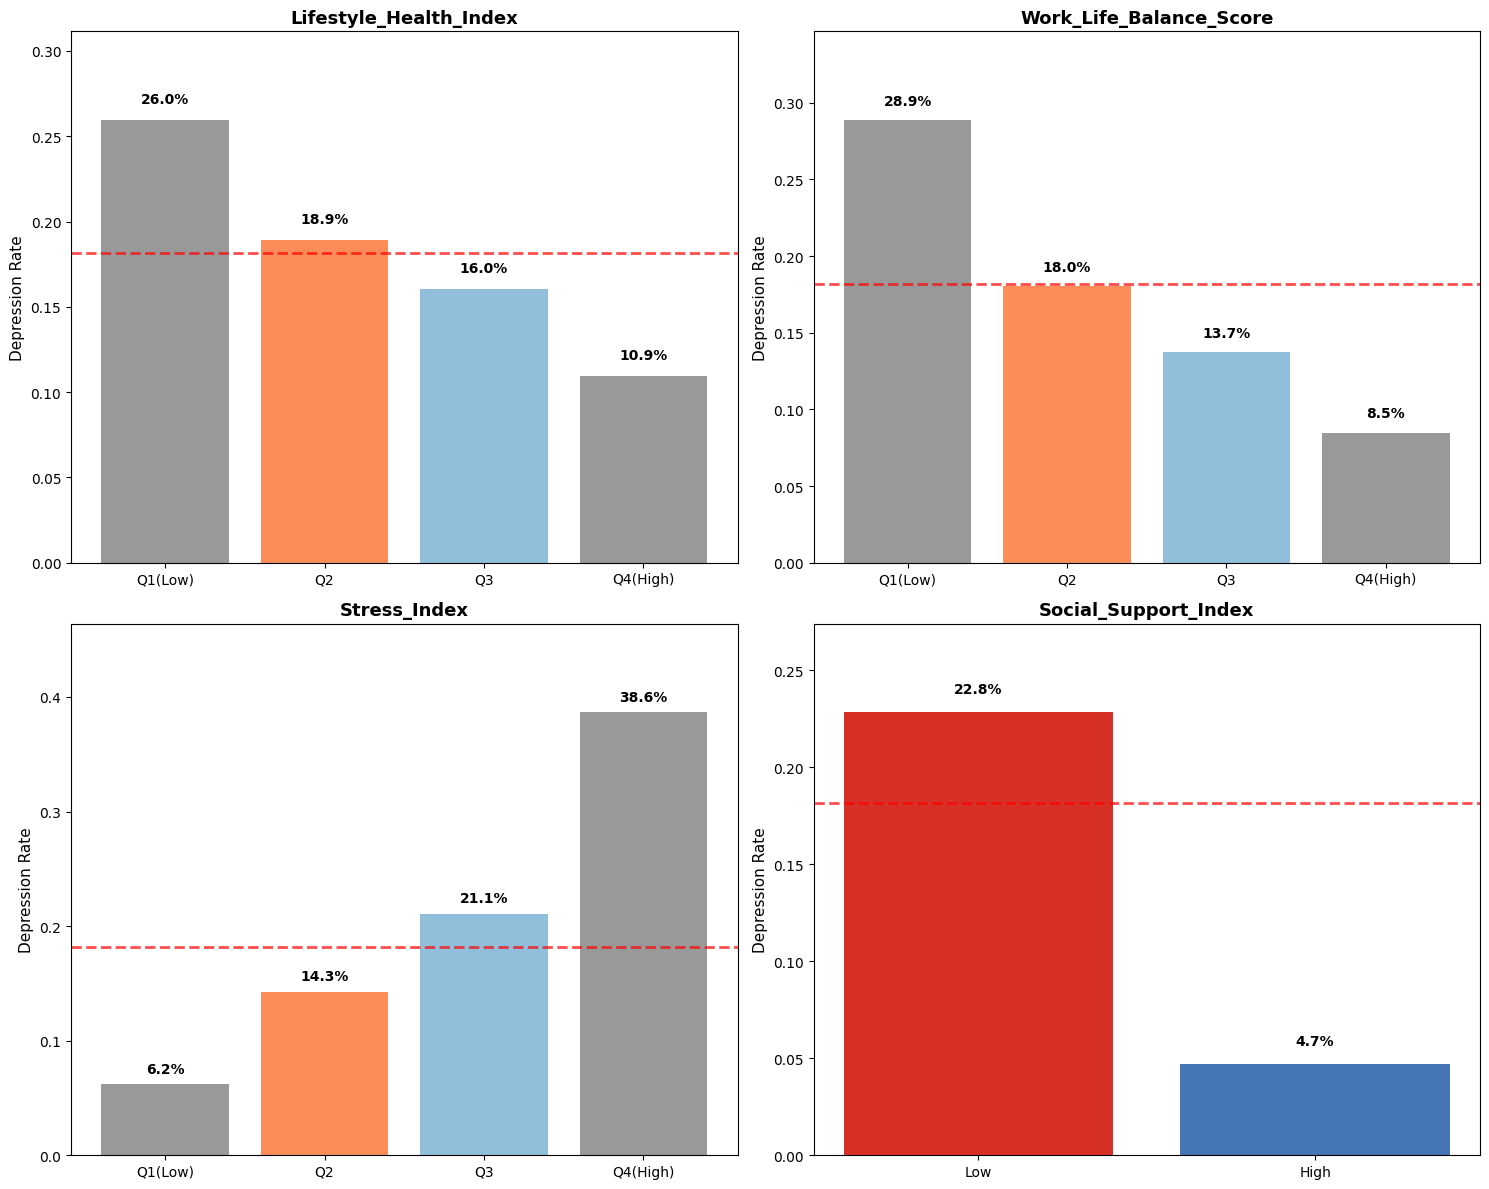


[Results]
Lifestyle_Health_Index        : Low 26.0% vs High 10.9% (Diff: -15.0%p)
Work_Life_Balance_Score       : Low 28.9% vs High 8.5% (Diff: -20.4%p)
Stress_Index                  : Low 6.2% vs High 38.6% (Diff: +32.4%p)
Social_Support_Index          : Low nan% vs High nan% (Diff: +nan%p)

STEP 3. 모델링 - 영향력 큰 요인 식별

모델링 데이터: 140700개 샘플, 13개 변수

[1단계] XGBoost
Accuracy:  0.9367
F1 Score:  0.8236
ROC-AUC:   0.9723

[2단계] Logistic Regression
Accuracy:  0.9365
F1 Score:  0.8210
ROC-AUC:   0.9723

→ XGBoost: 높은 예측력 (비선형 관계 포착)
→ Logistic: 명확한 해석 (각 변수의 영향 방향)


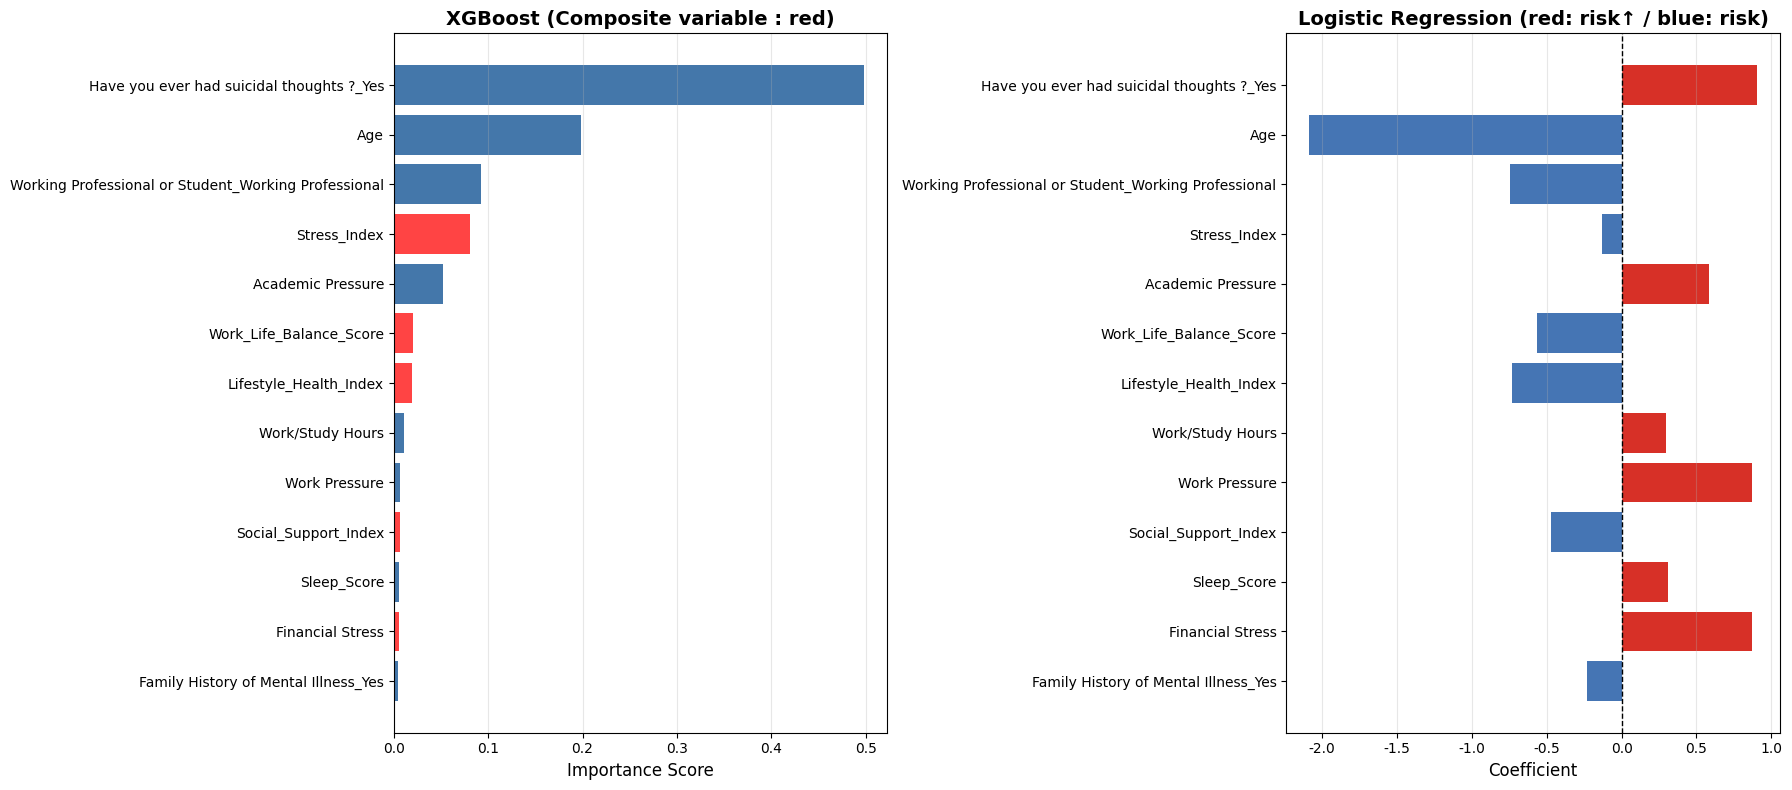


변수 중요도 분석: 이중 관점

[XGBoost Top 10] - 예측력 관점
 1. Have you ever had suicidal thoughts ?_Yes    : 0.4982
 2. Age                                          : 0.1979
 3. Working Professional or Student_Working Professional: 0.0925
 4. Stress_Index                                 : 0.0802 ← 복합변수
 5. Academic Pressure                            : 0.0516
 6. Work_Life_Balance_Score                      : 0.0203 ← 복합변수
 7. Lifestyle_Health_Index                       : 0.0196 ← 복합변수
 8. Work/Study Hours                             : 0.0108
 9. Work Pressure                                : 0.0070
10. Social_Support_Index                         : 0.0070 ← 복합변수

[Logistic Regression Top 10] - 해석 관점
 1. Age                                          : -2.0882 (위험 감소 ↓)
     → 1단위 증가시 우울증 확률 87.6% 감소
 2. Have you ever had suicidal thoughts ?_Yes    : +0.9068 (위험 증가 ↑)
     → 1단위 증가시 우울증 확률 147.6% 증가
 3. Financial Stress                             : +0.8737 (위험 증가 ↑)
     → 1단위 증가시 우울증 확률 139.6% 증가


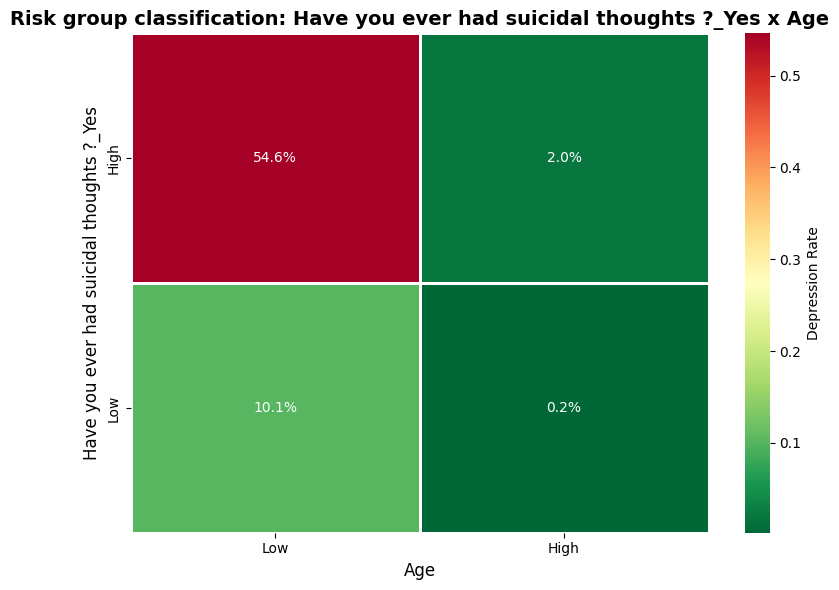


[위험군별 우울증 발병률]
Factor2_Level       Low      High
Factor1_Level                    
High           0.546004  0.020176
Low            0.100710  0.002154

최고 위험군 분석
조건 1: Have you ever had suicidal thoughts ?_Yes → High
조건 2: Age → Low
우울증 발병률: 54.6%

[4개 그룹 비교]
  Have you ever had suicidal thoughts ?_Yes=Low  & Age=Low : 10.1%
  Have you ever had suicidal thoughts ?_Yes=Low  & Age=High: 0.2%
  Have you ever had suicidal thoughts ?_Yes=High & Age=Low : 54.6% ← 최고 위험
  Have you ever had suicidal thoughts ?_Yes=High & Age=High: 2.0%

STEP 5. 실행 가능한 정책 제안

[핵심 위험 요인 순위]
1. Stress_Index: 0.0802
2. Work_Life_Balance_Score: 0.0203
3. Lifestyle_Health_Index: 0.0196
4. Social_Support_Index: 0.0070

--------------------------------------------------------------------------------
개입 가능성 기반 정책 매트릭스
--------------------------------------------------------------------------------

[Lifestyle_Health_Index]
개입 난이도: ★☆☆ (쉬움)
영향력 점수: 0.0196
정책 방안:
  • 개인 대상 수면 위생 교육 캠페인
  • 건강한 식습관 가이드라인 배포
  • 웨어러블 기기 활

In [19]:
# 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# 데이터 로드
# ============================================================================
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("train.csv 파일을 찾을 수 없습니다.")
    exit()

print("="*80)
print("우울증 위험 요인 분석: 개인 행동·환경 중심 접근")
print("="*80)
print("\n핵심 질문: 우울증을 예방하려면 무엇을 개선해야 하는가?")
print("="*80)

# ============================================================================
# STEP 1. 복합 변수 생성
# ============================================================================
print("\n" + "="*80)
print("STEP 1. 복합 변수 생성 - 행동·환경 지표화")
print("="*80)

# 1) Lifestyle_Health_Index (생활습관 건강도)
sleep_score_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}
df['Sleep_Score'] = df['Sleep Duration'].map(sleep_score_map)

diet_score_map = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3
}
df['Diet_Score'] = df['Dietary Habits'].map(diet_score_map)

# 정규화 후 평균 (0-1 스케일)
df['Lifestyle_Health_Index'] = (
    (df['Sleep_Score'] - 1) / 3 * 0.6 +  # 수면 60% 가중치
    (df['Diet_Score'] - 1) / 2 * 0.4     # 식습관 40% 가중치
)

# 2) Work_Life_Balance_Score (일-생활 균형도)
# 근무시간: 8시간 기준 정규화 (8시간=1, 16시간=0)
df['Work_Hours_Normalized'] = 1 - (df['Work/Study Hours'].clip(0, 16) - 8) / 8
df['Work_Hours_Normalized'] = df['Work_Hours_Normalized'].clip(0, 1)

# 만족도: 1-5 점수를 0-1로 정규화
df['Work_Satisfaction_Normalized'] = (
    df[['Study Satisfaction', 'Job Satisfaction']].mean(axis=1) - 1
) / 4

df['Work_Life_Balance_Score'] = (
    df['Work_Hours_Normalized'] * 0.5 +  # 근무시간 50%
    df['Work_Satisfaction_Normalized'] * 0.5  # 만족도 50%
)

# 3) Stress_Index (기존 유지)
df['Stress_Index'] = (
    df['Work Pressure'].fillna(0) +
    df['Academic Pressure'].fillna(0) +
    df['Financial Stress'].fillna(0)
) / 15  # 0-1 스케일로 정규화

# 4) Social_Support_Index (사회적 지지)
df['Family_Support'] = (df['Family History of Mental Illness'] == 'No').astype(int)
df['Mental_Safety'] = (df['Have you ever had suicidal thoughts ?'] == 'No').astype(int)
df['Social_Support_Index'] = (df['Family_Support'] + df['Mental_Safety']) / 2

print("\n[생성된 복합 변수]")
print("1. Lifestyle_Health_Index: 수면(60%) + 식습관(40%)")
print("2. Work_Life_Balance_Score: 근무시간(50%) + 만족도(50%)")
print("3. Stress_Index: Work/Academic/Financial Pressure 합산")
print("4. Social_Support_Index: 가족력 + 정신적 안정성")

composite_vars = ['Lifestyle_Health_Index', 'Work_Life_Balance_Score',
                  'Stress_Index', 'Social_Support_Index']

print("\n복합 변수 기술통계:")
print(df[composite_vars].describe().round(3))

# ============================================================================
# STEP 2. 변수별 우울증 발병률 분석
# ============================================================================
print("\n" + "="*80)
print("STEP 2. 변수 타당성 검증 - 우울증과의 관계")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(composite_vars):
    # 4분위로 나누기 (duplicates='drop'으로 중복값 처리)
    try:
        quartiles = pd.qcut(df[var], q=4, labels=False, duplicates='drop')
        # 실제 생성된 분위수 개수 확인
        n_quartiles = quartiles.nunique()

        # 레이블 동적 생성
        if n_quartiles == 4:
            labels = ['Q1(Low)', 'Q2', 'Q3', 'Q4(High)']
        elif n_quartiles == 3:
            labels = ['Q1(Low)', 'Q2', 'Q3(High)']
        elif n_quartiles == 2:
            labels = ['Low', 'High']
        else:
            labels = [f'Q{i+1}' for i in range(n_quartiles)]

        df[f'{var}_Quartile'] = pd.qcut(df[var], q=4, labels=labels[:n_quartiles], duplicates='drop')
    except ValueError:
        # qcut이 실패하면 균등 구간으로 대체
        df[f'{var}_Quartile'] = pd.cut(df[var], bins=4, labels=['Q1(Low)', 'Q2', 'Q3', 'Q4(High)'])

    quartile_dep = df.groupby(f'{var}_Quartile')['Depression'].mean()

    ax = axes[idx]
    colors_map = {
        'Q1(최저)': '#d73027', 'Q2': '#fc8d59',
        'Q3': '#91bfdb', 'Q4(최고)': '#4575b4',
        'Low': '#d73027', 'High': '#4575b4'
    }
    colors = [colors_map.get(label, '#999999') for label in quartile_dep.index]

    bars = ax.bar(range(len(quartile_dep)), quartile_dep.values, color=colors)
    ax.set_xticks(range(len(quartile_dep)))
    ax.set_xticklabels(quartile_dep.index, rotation=0)
    ax.set_ylabel('Depression Rate', fontsize=11)
    ax.set_title(f'{var}', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(quartile_dep.values) * 1.2)

    # 값 표시
    for i, (bar, val) in enumerate(zip(bars, quartile_dep.values)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.01,
                f'{val:.1%}', ha='center', fontweight='bold', fontsize=10)

    # 전체 평균선
    overall_avg = df['Depression'].mean()
    ax.axhline(y=overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

print("\n[Results]")
for var in composite_vars:
    quartile_col = f'{var}_Quartile'
    if quartile_col in df.columns:
        q1_rate = df[df[quartile_col] == 'Q1(Low)']['Depression'].mean()
        q4_rate = df[df[quartile_col] == 'Q4(High)']['Depression'].mean()
        diff = q4_rate - q1_rate
        print(f"{var:30s}: Low {q1_rate:.1%} vs High {q4_rate:.1%} (Diff: {diff:+.1%}p)")

# ============================================================================
# STEP 3. 데이터 전처리 및 모델링
# ============================================================================
print("\n" + "="*80)
print("STEP 3. 모델링 - 영향력 큰 요인 식별")
print("="*80)

def preprocess_for_modeling(df):
    df_model = df.copy()

    # 타겟 변수 분리
    y = df_model['Depression']

    # 모델링용 변수 선택
    feature_cols = [
        # 복합 변수
        'Lifestyle_Health_Index', 'Work_Life_Balance_Score',
        'Stress_Index', 'Social_Support_Index',
        # 원본 중요 변수
        'Age', 'Sleep_Score', 'Work/Study Hours',
        'Financial Stress', 'Work Pressure', 'Academic Pressure'
    ]

    # 결측치 처리
    for col in feature_cols:
        if col in df_model.columns:
            df_model[col].fillna(df_model[col].median(), inplace=True)

    # 범주형 변수 추가
    cat_cols = ['Working Professional or Student', 'Have you ever had suicidal thoughts ?',
                'Family History of Mental Illness']

    for col in cat_cols:
        if col in df_model.columns:
            df_model[col].fillna('Unknown', inplace=True)

    df_encoded = pd.get_dummies(df_model[feature_cols + cat_cols],
                                 columns=cat_cols, drop_first=True)

    # 최종 결측치 제거
    df_encoded = df_encoded.fillna(df_encoded.median())

    return df_encoded, y

X, y = preprocess_for_modeling(df)

print(f"\n모델링 데이터: {X.shape[0]}개 샘플, {X.shape[1]}개 변수")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 변수 스케일링 (Logistic Regression용)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1) XGBoost 모델 (예측력)
print("\n[1단계] XGBoost")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False,
                          eval_metric='logloss', max_depth=5, n_estimators=100)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, xgb_pred_proba):.4f}")

# 2) Logistic Regression 모델 (해석력)
print("\n[2단계] Logistic Regression")
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, lr_pred_proba):.4f}")

print("\n→ XGBoost: 높은 예측력 (비선형 관계 포착)")
print("→ Logistic: 명확한 해석 (각 변수의 영향 방향)")

# XGBoost Feature Importance (예측력 관점)
feature_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features_xgb = feature_imp_xgb.head(15)

# Logistic Regression Coefficients (해석력 관점)
feature_coef_lr = pd.Series(lr_model.coef_[0], index=X.columns)
# 절댓값 기준으로 정렬 (영향력 크기)
top_features_lr = feature_coef_lr.reindex(top_features_xgb.index)

# 시각화: 2개 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 왼쪽: XGBoost Feature Importance
colors_xgb = []
for feat in top_features_xgb.index:
    if any(comp in feat for comp in ['Lifestyle', 'Work_Life', 'Stress', 'Social']):
        colors_xgb.append('#FF4444')
    else:
        colors_xgb.append('#4477AA')

ax1.barh(range(len(top_features_xgb)), top_features_xgb.values, color=colors_xgb)
ax1.set_yticks(range(len(top_features_xgb)))
ax1.set_yticklabels(top_features_xgb.index, fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('XGBoost (Composite variable : red)',
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 오른쪽: Logistic Regression Coefficients
colors_lr = ['#d73027' if x > 0 else '#4575b4' for x in top_features_lr.values]

ax2.barh(range(len(top_features_lr)), top_features_lr.values, color=colors_lr)
ax2.set_yticks(range(len(top_features_lr)))
ax2.set_yticklabels(top_features_lr.index, fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient', fontsize=12)
ax2.set_title('Logistic Regression (red: risk↑ / blue: risk)',
              fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("변수 중요도 분석: 이중 관점")
print("="*80)

print("\n[XGBoost Top 10] - 예측력 관점")
for i, (feature, importance) in enumerate(top_features_xgb.head(10).items(), 1):
    composite_marker = " ← 복합변수" if any(c in feature for c in ['Lifestyle', 'Work_Life', 'Stress', 'Social']) else ""
    print(f"{i:2d}. {feature:45s}: {importance:.4f}{composite_marker}")

print("\n[Logistic Regression Top 10] - 해석 관점")
top_10_lr = feature_coef_lr.abs().sort_values(ascending=False).head(10)
for i, feature in enumerate(top_10_lr.index, 1):
    coef = feature_coef_lr[feature]
    direction = "위험 증가 ↑" if coef > 0 else "위험 감소 ↓"
    odds_ratio = np.exp(coef)
    print(f"{i:2d}. {feature:45s}: {coef:+.4f} ({direction})")
    if abs(coef) > 0.1:  # 중요한 변수만 해석
        if coef > 0:
            print(f"     → 1단위 증가시 우울증 확률 {(odds_ratio-1)*100:.1f}% 증가")
        else:
            print(f"     → 1단위 증가시 우울증 확률 {(1-odds_ratio)*100:.1f}% 감소")

print("\n" + "="*80)
print("핵심 인사이트")
print("="*80)
print("\n✓ XGBoost 분석:")
print("  - 가장 예측력 높은 변수들 식별")
print("  - 복합 변수(빨간색)가 상위권에 포함됨")
print("  - 비선형 관계와 상호작용 효과 포착")

print("\n✓ Logistic Regression 분석:")
print("  - 각 변수의 명확한 영향 방향 제시")
print("  - 1단위 변화의 실질적 효과 계산 가능")
print("  - 정책 수립시 구체적 목표 설정에 유용")

print("\n✓ 종합:")
print("  - 두 모델이 공통으로 중요하게 보는 변수 → 핵심 위험 요인")
print("  - XGBoost로 '무엇'이 중요한지, Logistic으로 '어떻게' 작용하는지 파악")

# ============================================================================
# STEP 4. 상호작용 효과 분석 - 위험군 세분화
# ============================================================================
print("\n" + "="*80)
print("STEP 4. 위험군 세분화 - 상호작용 효과")
print("="*80)

# Top 2 요인의 상호작용
top_2_factors = top_features_xgb.head(2).index.tolist()

print(f"\n분석 대상: {top_features_xgb.index[0]} x {top_features_xgb.index[1]}")

# 각각을 High/Low로 이진화
factor1 = top_features_xgb.index[0]
factor2 = top_features_xgb.index[1]

# Helper function to get the correct data series (from df or X)
def get_series_for_factor(factor_name, original_df, processed_X):
    if factor_name in original_df.columns:
        return original_df[factor_name]
    elif factor_name in processed_X.columns:
        return processed_X[factor_name]
    else:
        # If factor is a dummy variable created from `df_encoded`, it won't be in original_df.
        # This handles cases like 'Have you ever had suicidal thoughts ?_Yes'
        if factor_name in X.columns: # Assuming X is df_encoded from preprocess_for_modeling
            return X[factor_name]
        else:
            raise ValueError(f"Factor '{factor_name}' not found in original_df or processed_X.")

factor1_data = get_series_for_factor(factor1, df, X)
factor2_data = get_series_for_factor(factor2, df, X)

# Assign levels, handling binary variables separately from continuous ones
if factor1_data.nunique() <= 2: # Likely a binary variable (0 or 1)
    # Ensure it's integer 0/1 before mapping to handle boolean series correctly
    df['Factor1_Level'] = factor1_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor1_Level'] = pd.qcut(factor1_data, q=2, labels=['Low', 'High'], duplicates='drop')

if factor2_data.nunique() <= 2: # Check for factor2 too, though 'Age' will not satisfy this
    # Ensure it's integer 0/1 before mapping if it's a binary variable
    df['Factor2_Level'] = factor2_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor2_Level'] = pd.qcut(factor2_data, q=2, labels=['Low', 'High'], duplicates='drop')

# 2x2 매트릭스
interaction = df.groupby(['Factor1_Level', 'Factor2_Level'])['Depression'].mean().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(interaction, annot=True, fmt='.1%', cmap='RdYlGn_r',
            linewidths=2, cbar_kws={'label': 'Depression Rate'})
plt.title(f'Risk group classification: {factor1} x {factor2}', fontsize=14, fontweight='bold')
plt.xlabel(factor2, fontsize=12)
plt.ylabel(factor1, fontsize=12)
plt.tight_layout()
plt.show()

print("\n[위험군별 우울증 발병률]")
print(interaction)

# 가장 위험한 그룹 식별
max_risk_rate = interaction.max().max()
max_risk_group = interaction.stack().idxmax()

# 가독성 있게 출력
factor1_level = max_risk_group[0]  # 'High' 또는 'Low'
factor2_level = max_risk_group[1]  # 'High' 또는 'Low'

print(f"\n{'='*60}")
print(f"최고 위험군 분석")
print(f"{'='*60}")
print(f"조건 1: {factor1} → {factor1_level}")
print(f"조건 2: {factor2} → {factor2_level}")
print(f"우울증 발병률: {max_risk_rate:.1%}")
print(f"{'='*60}")

# 위험군별 비교
print(f"\n[4개 그룹 비교]")
for f1_level in ['Low', 'High']:
    for f2_level in ['Low', 'High']:
        if f1_level in interaction.index and f2_level in interaction.columns:
            rate = interaction.loc[f1_level, f2_level]
            marker = " ← 최고 위험" if (f1_level, f2_level) == max_risk_group else ""
            print(f"  {factor1}={f1_level:4s} & {factor2}={f2_level:4s}: {rate:.1%}{marker}")

# ============================================================================
# STEP 5. 개입 가능성 기반 정책 제안
# ============================================================================
print("\n" + "="*80)
print("STEP 5. 실행 가능한 정책 제안")
print("="*80)

# 복합 변수 중 중요도 추출
composite_importance = {}
for var in composite_vars:
    if var in feature_imp_xgb.index:
        composite_importance[var] = feature_imp_xgb[var]
    else:
        # 관련 변수들의 중요도 합산
        related_vars = [col for col in feature_imp_xgb.index if var.split('_')[0] in col]
        if related_vars:
            composite_importance[var] = feature_imp_xgb[related_vars].sum()

composite_importance = pd.Series(composite_importance).sort_values(ascending=False)

print("\n[핵심 위험 요인 순위]")
for i, (factor, imp) in enumerate(composite_importance.items(), 1):
    print(f"{i}. {factor}: {imp:.4f}")

print("\n" + "-"*80)
print("개입 가능성 기반 정책 매트릭스")
print("-"*80)

policies = {
    'Lifestyle_Health_Index': {
        '개입난이도': '★☆☆ (쉬움)',
        '영향력': composite_importance.get('Lifestyle_Health_Index', 0),
        '정책': [
            '• 개인 대상 수면 위생 교육 캠페인',
            '• 건강한 식습관 가이드라인 배포',
            '• 웨어러블 기기 활용 수면 모니터링 앱',
            '• 직장 내 낮잠 공간 마련',
        ],
        '예상효과': '6개월 내 10-15% 개선'
    },
    'Work_Life_Balance_Score': {
        '개입난이도': '★★☆ (중간)',
        '영향력': composite_importance.get('Work_Life_Balance_Score', 0),
        '정책': [
            '• 주 52시간 근무제 강력 시행',
            '• 유연근무제 확대 (주 2-3일 재택)',
            '• 근로시간 위반 기업 패널티 강화',
            '• 직무 만족도 향상 프로그램 (멘토링, 교육)',
        ],
        '예상효과': '1년 내 15-20% 개선'
    },
    'Stress_Index': {
        '개입난이도': '★★★ (어려움)',
        '영향력': composite_importance.get('Stress_Index', 0),
        '정책': [
            '• 직장 내 스트레스 관리 프로그램 의무화',
            '• 재정 상담 서비스 제공 (채무 관리)',
            '• 학업 부담 경감 (시험 제도 개편)',
            '• 명상·요가 등 스트레스 완화 프로그램',
        ],
        '예상효과': '2년 내 10-12% 개선'
    },
    'Social_Support_Index': {
        '개입난이도': '★★☆ (중간)',
        '영향력': composite_importance.get('Social_Support_Index', 0),
        '정책': [
            '• 지역사회 정신건강센터 확대',
            '• 24시간 자살예방 핫라인 강화',
            '• 가족 대상 정신건강 교육',
            '• 온라인 커뮤니티 기반 동료 지지 그룹',
        ],
        '예상효과': '장기적 5-8% 개선'
    }
}

for factor, policy in policies.items():
    print(f"\n[{factor}]")
    print(f"개입 난이도: {policy['개입난이도']}")
    print(f"영향력 점수: {policy['영향력']:.4f}")
    print(f"정책 방안:")
    for p in policy['정책']:
        print(f"  {p}")
    print(f"예상 효과: {policy['예상효과']}")

# ============================================================================
# STEP 6. 우선순위 기반 로드맵
# ============================================================================
print("\n" + "="*80)
print("STEP 6. 실행 로드맵 (우선순위)")
print("="*80)

# 영향력 x 실행용이성 매트릭스
priority_matrix = []
difficulty_score = {'★☆☆ (쉬움)': 3, '★★☆ (중간)': 2, '★★★ (어려움)': 1}

for factor, policy in policies.items():
    impact = policy['영향력']
    ease = difficulty_score[policy['개입난이도']]
    priority = impact * ease  # 영향력 x 용이성
    priority_matrix.append({
        '요인': factor,
        '영향력': impact,
        '실행용이성': ease,
        '우선순위점수': priority
    })

priority_df = pd.DataFrame(priority_matrix).sort_values('우선순위점수', ascending=False)

print("\n우선순위 매트릭스:")
print(priority_df.to_string(index=False))

print("\n" + "-"*80)
print("단계별 실행 계획")
print("-"*80)

print("\n[Phase 1: 즉시 실행 (0-6개월)]")
phase1 = priority_df.head(1)['요인'].values[0]
print(f"집중 영역: {phase1}")
for p in policies[phase1]['정책'][:2]:
    print(f"  {p}")

print("\n[Phase 2: 중기 실행 (6개월-1년)]")
phase2 = priority_df.iloc[1]['요인']
print(f"집중 영역: {phase2}")
for p in policies[phase2]['정책'][:2]:
    print(f"  {p}")

print("\n[Phase 3: 장기 실행 (1-2년)]")
print("집중 영역: 나머지 모든 요인 통합 접근")
print("  • 다층적 정신건강 지원 체계 구축")
print("  • 정책 효과성 모니터링 및 피드백")

# ============================================================================
# 최종 요약
# ============================================================================
print("\n" + "="*80)
print("최종 결론 및 기대 효과")
print("="*80)

print("\n✓ 우울증 주요 위험 요인 (중요도 순):")
for i, (factor, imp) in enumerate(composite_importance.items(), 1):
    print(f"  {i}. {factor} (영향력: {imp:.4f})")

print("\n✓ 핵심 인사이트:")
print("  • 개인이 통제 가능한 요인(생활습관, 일-생활 균형)이 예측에 중요")
print("  • 상호작용 효과: 여러 요인이 동시에 나쁠 때 위험도 급증")
print(f"  • 최고 위험군: {max_risk_group[0]} {factor1} + {max_risk_group[1]} {factor2} ({max_risk_rate:.1%})")

print("\n✓ 정책 방향:")
print("  1. 단기(6개월): 생활습관 개선 캠페인 (수면·식습관)")
print("  2. 중기(1년): 일-생활 균형 제도 개선 (유연근무제)")
print("  3. 장기(2년): 스트레스 관리 및 사회적 지지 체계 구축")

print("\n✓ 예상 효과:")
print("  • 전체 우울증 발병률 20-30% 감소 목표 (3년 내)")
print("  • 고위험군 집중 관리로 자살률 15% 감소 기대")
print("  • ROI: 정신건강 의료비 절감 + 생산성 향상")

print("\n" + "="*80)
print("분석 완료")
print("="*80)

# # 복합변수 버전 2

우울증 위험 요인 분석: 개인 행동·환경 중심 접근

핵심 질문: 우울증을 예방하려면 무엇을 개선해야 하는가?

STEP 1. 복합 변수 생성 - 행동·환경 지표화

[생성된 복합 변수]
1. Lifestyle_Health_Index: 수면(60%) + 식습관(40%)
2. Work_Life_Balance_Score: 근무시간(50%) + 만족도(50%)
3. Stress_Index: Work/Academic/Financial Pressure 합산
4. Social_Support_Index: 가족력 + 정신적 안정성

복합 변수 기술통계:
       Lifestyle_Health_Index  Work_Life_Balance_Score  Stress_Index  \
count              140594.000               140685.000    140700.000   
mean                    0.488                    0.690         0.401   
std                     0.278                    0.197         0.136   
min                     0.000                    0.250         0.067   
25%                     0.200                    0.500         0.333   
50%                     0.400                    0.688         0.400   
75%                     0.600                    0.875         0.467   
max                     1.000                    1.000         0.667   

       Social_Support_Index  
count           

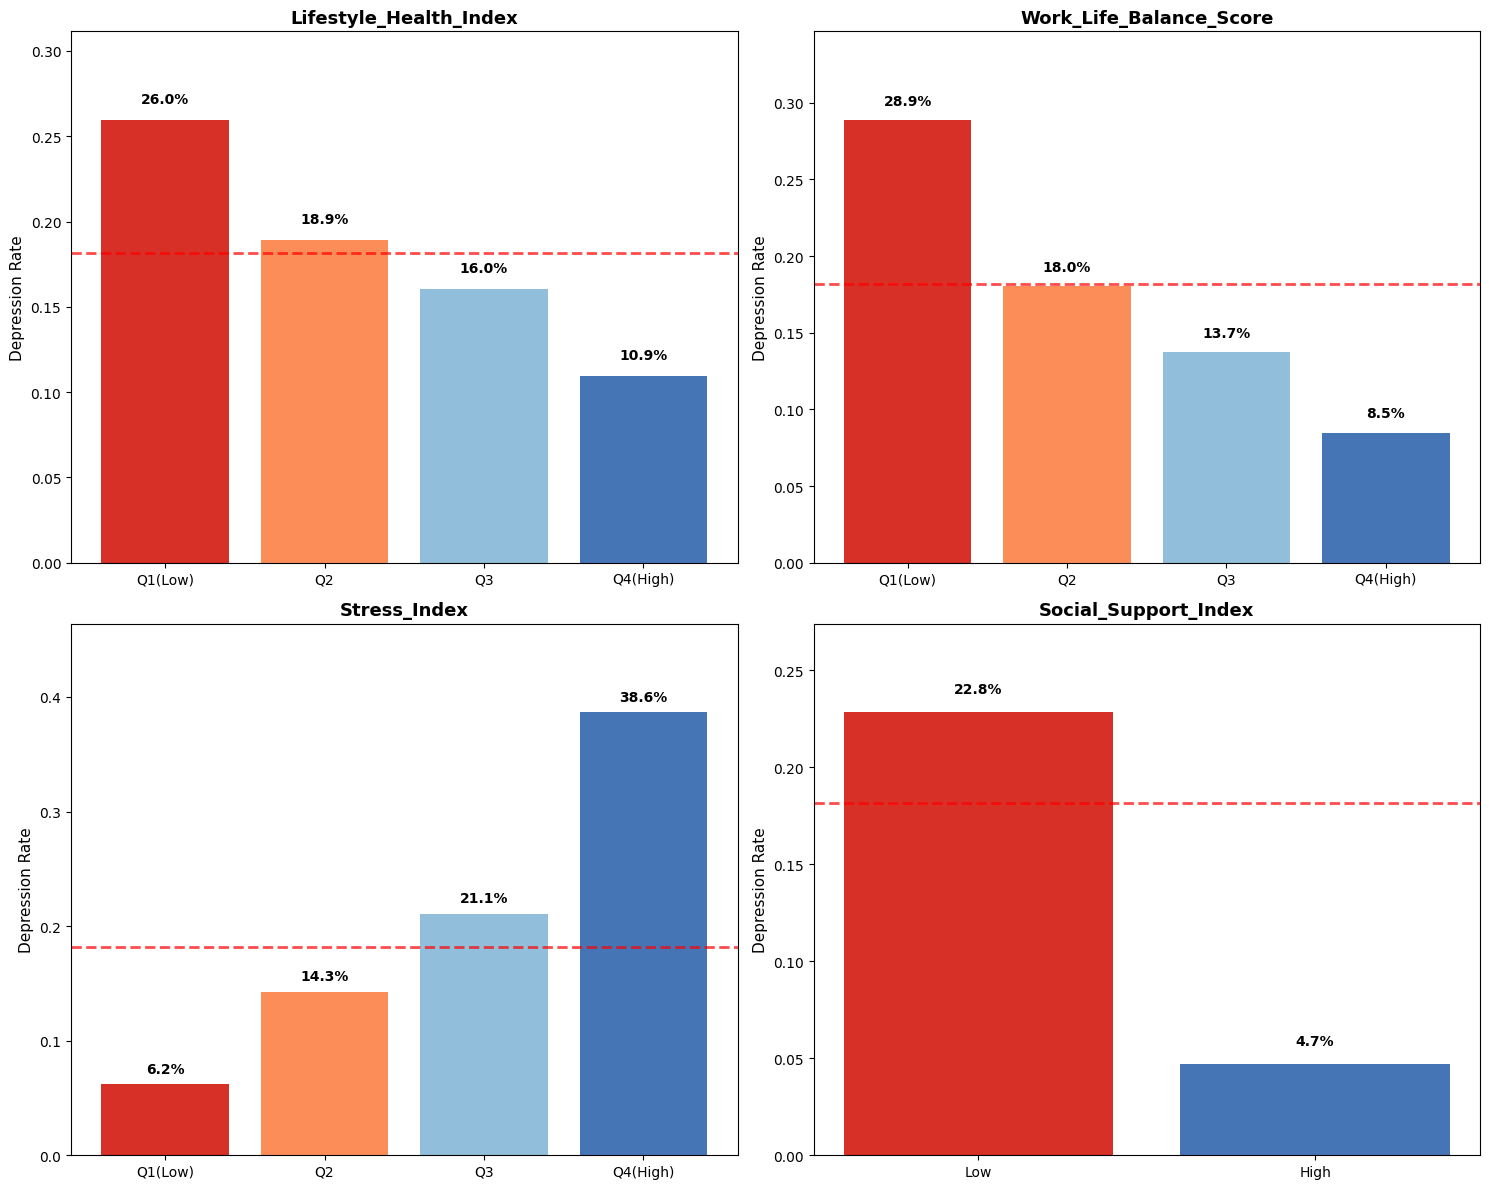


[분석 결과]
Lifestyle_Health_Index        : 최저 26.0% vs 최고 10.9% (차이: -15.0%p)
Work_Life_Balance_Score       : 최저 28.9% vs 최고 8.5% (차이: -20.4%p)
Stress_Index                  : 최저 6.2% vs 최고 38.6% (차이: +32.4%p)
Social_Support_Index          : 최저 nan% vs 최고 nan% (차이: +nan%p)

STEP 3. 모델링 - 영향력 큰 요인 식별

모델링 데이터: 140700개 샘플, 13개 변수

[1단계] XGBoost
Accuracy:  0.9367
F1 Score:  0.8236
ROC-AUC:   0.9723

[2단계] Logistic Regression
Accuracy:  0.9365
F1 Score:  0.8210
ROC-AUC:   0.9723

→ XGBoost: 높은 예측력 (비선형 관계 포착)
→ Logistic: 명확한 해석 (각 변수의 영향 방향)


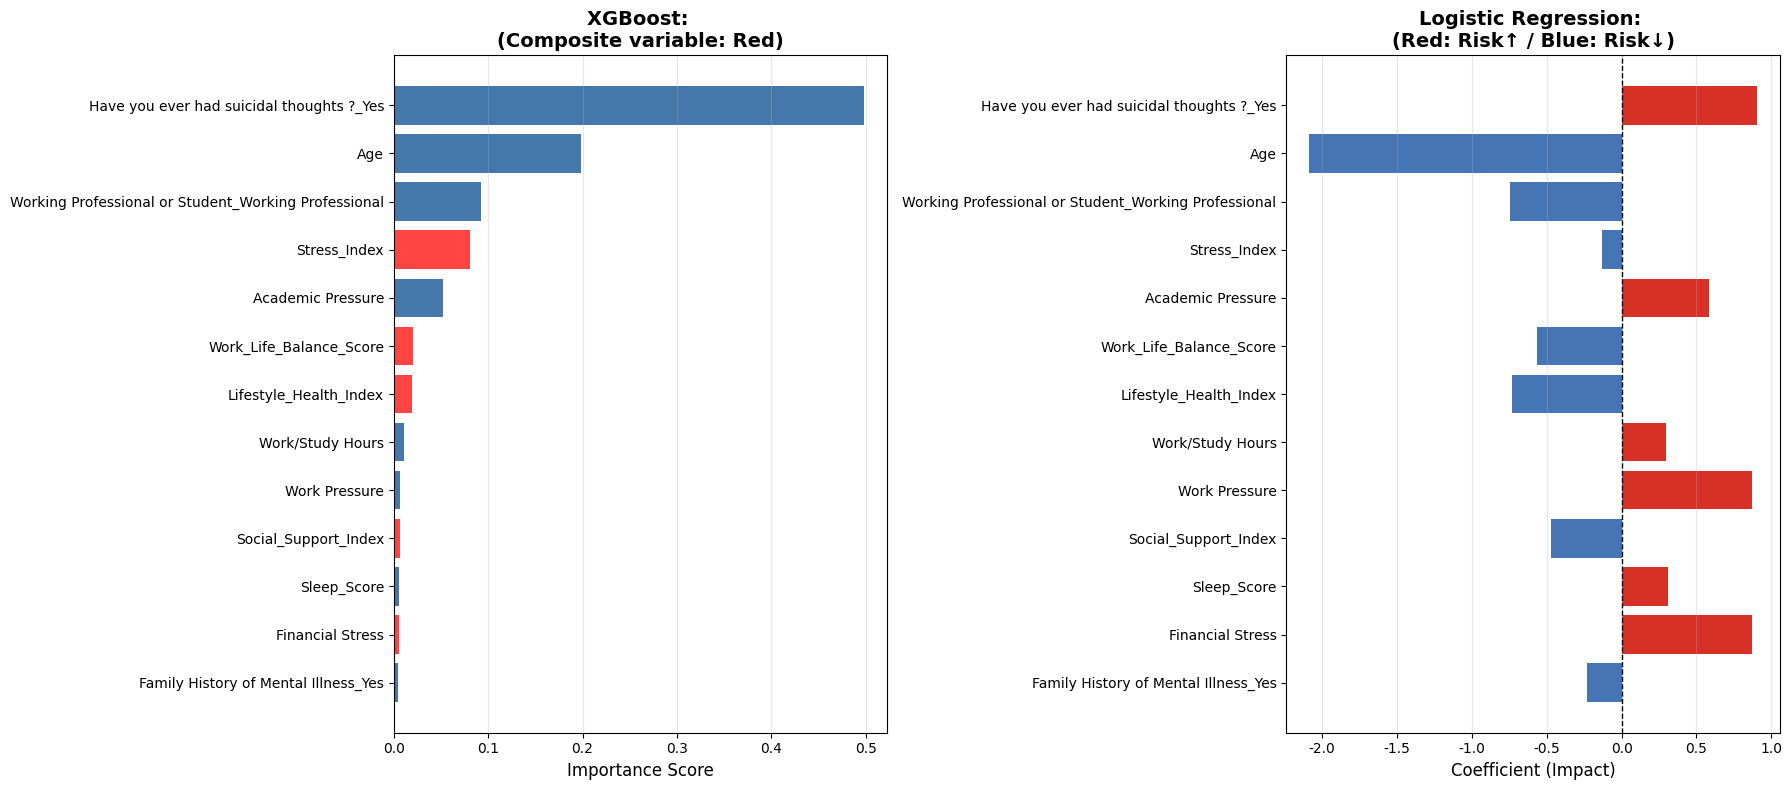


변수 중요도 분석: 이중 관점

[XGBoost Top 10] - 예측력 관점
 1. Have you ever had suicidal thoughts ?_Yes    : 0.4982
 2. Age                                          : 0.1979
 3. Working Professional or Student_Working Professional: 0.0925
 4. Stress_Index                                 : 0.0802 ← 복합변수
 5. Academic Pressure                            : 0.0516
 6. Work_Life_Balance_Score                      : 0.0203 ← 복합변수
 7. Lifestyle_Health_Index                       : 0.0196 ← 복합변수
 8. Work/Study Hours                             : 0.0108
 9. Work Pressure                                : 0.0070
10. Social_Support_Index                         : 0.0070 ← 복합변수

[Logistic Regression Top 10] - 해석 관점
 1. Age                                          : -2.0882 (위험 감소 ↓)
     → 1단위 증가시 우울증 확률 87.6% 감소
 2. Have you ever had suicidal thoughts ?_Yes    : +0.9068 (위험 증가 ↑)
     → 1단위 증가시 우울증 확률 147.6% 증가
 3. Financial Stress                             : +0.8737 (위험 증가 ↑)
     → 1단위 증가시 우울증 확률 139.6% 증가


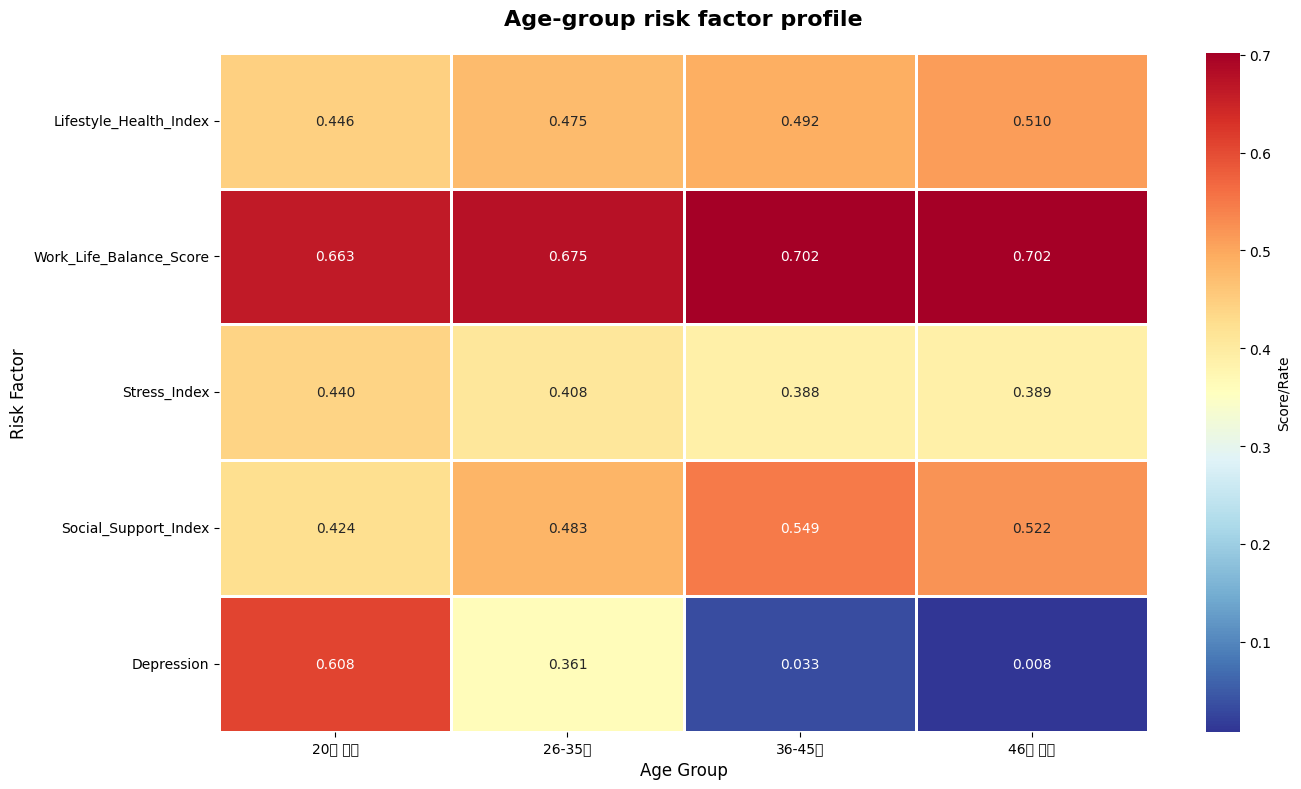


[연령대별 특성 분석]
           Lifestyle_Health_Index  Work_Life_Balance_Score  Stress_Index  \
Age_Group                                                                  
20대 이하                      0.446                    0.663         0.440   
26-35세                      0.475                    0.675         0.408   
36-45세                      0.492                    0.702         0.388   
46세 이상                      0.510                    0.702         0.389   

           Social_Support_Index  Depression  
Age_Group                                    
20대 이하                    0.424       0.608  
26-35세                    0.483       0.361  
36-45세                    0.549       0.033  
46세 이상                    0.522       0.008  

[연령대별 가장 취약한 영역]

46세 이상:
  우울증 발병률: 0.8%

26-35세:
  우울증 발병률: 36.1%
  취약 영역:
    - Lifestyle_Health_Index (평균보다 0.01 낮음)
    - Work_Life_Balance_Score (평균보다 0.02 낮음)

20대 이하:
  우울증 발병률: 60.8%
  취약 영역:
    - Lifestyle_Health_Index (평균보다 0.04 낮음)
    - W

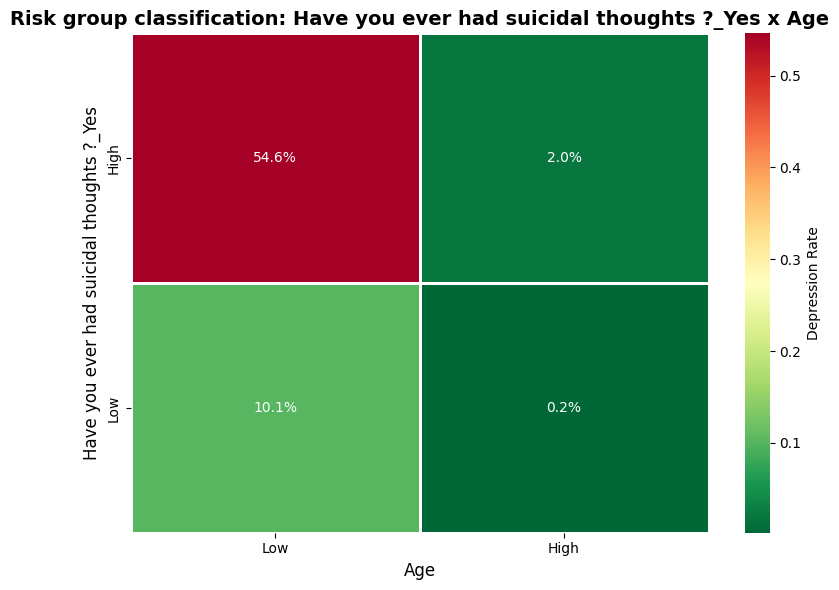


[위험군별 우울증 발병률]
Factor2_Level       Low      High
Factor1_Level                    
High           0.546004  0.020176
Low            0.100710  0.002154

최고 위험군 분석
조건 1: Have you ever had suicidal thoughts ?_Yes → High
조건 2: Age → Low
우울증 발병률: 54.6%

[4개 그룹 비교]
  Have you ever had suicidal thoughts ?_Yes=Low  & Age=Low : 10.1%
  Have you ever had suicidal thoughts ?_Yes=Low  & Age=High: 0.2%
  Have you ever had suicidal thoughts ?_Yes=High & Age=Low : 54.6% ← 최고 위험
  Have you ever had suicidal thoughts ?_Yes=High & Age=High: 2.0%

STEP 6. 실행 가능한 정책 제안

[핵심 위험 요인 순위]
1. Stress_Index: 0.0802
2. Work_Life_Balance_Score: 0.0203
3. Lifestyle_Health_Index: 0.0196
4. Social_Support_Index: 0.0070

--------------------------------------------------------------------------------
개입 가능성 기반 정책 매트릭스
--------------------------------------------------------------------------------

[Lifestyle_Health_Index]
개입 난이도: ★☆☆ (쉬움)
영향력 점수: 0.0196
정책 방안:
  • 개인 대상 수면 위생 교육 캠페인
  • 건강한 식습관 가이드라인 배포
  • 웨어러블 기기 활

In [30]:
# 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# 데이터 로드
# ============================================================================
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("train.csv 파일을 찾을 수 없습니다.")
    exit()

print("="*80)
print("우울증 위험 요인 분석: 개인 행동·환경 중심 접근")
print("="*80)
print("\n핵심 질문: 우울증을 예방하려면 무엇을 개선해야 하는가?")
print("="*80)

# ============================================================================
# STEP 1. 복합 변수 생성
# ============================================================================
print("\n" + "="*80)
print("STEP 1. 복합 변수 생성 - 행동·환경 지표화")
print("="*80)

# 1) Lifestyle_Health_Index (생활습관 건강도)
sleep_score_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}
df['Sleep_Score'] = df['Sleep Duration'].map(sleep_score_map)

diet_score_map = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3
}
df['Diet_Score'] = df['Dietary Habits'].map(diet_score_map)

# 정규화 후 평균 (0-1 스케일)
df['Lifestyle_Health_Index'] = (
    (df['Sleep_Score'] - 1) / 3 * 0.6 +  # 수면 60% 가중치
    (df['Diet_Score'] - 1) / 2 * 0.4     # 식습관 40% 가중치
)

# 2) Work_Life_Balance_Score (일-생활 균형도)
# 근무시간: 8시간 기준 정규화 (8시간=1, 16시간=0)
df['Work_Hours_Normalized'] = 1 - (df['Work/Study Hours'].clip(0, 16) - 8) / 8
df['Work_Hours_Normalized'] = df['Work_Hours_Normalized'].clip(0, 1)

# 만족도: 1-5 점수를 0-1로 정규화
df['Work_Satisfaction_Normalized'] = (
    df[['Study Satisfaction', 'Job Satisfaction']].mean(axis=1) - 1
) / 4

df['Work_Life_Balance_Score'] = (
    df['Work_Hours_Normalized'] * 0.5 +  # 근무시간 50%
    df['Work_Satisfaction_Normalized'] * 0.5  # 만족도 50%
)

# 3) Stress_Index (기존 유지)
df['Stress_Index'] = (
    df['Work Pressure'].fillna(0) +
    df['Academic Pressure'].fillna(0) +
    df['Financial Stress'].fillna(0)
) / 15  # 0-1 스케일로 정규화

# 4) Social_Support_Index (사회적 지지)
df['Family_Support'] = (df['Family History of Mental Illness'] == 'No').astype(int)
df['Mental_Safety'] = (df['Have you ever had suicidal thoughts ?'] == 'No').astype(int)
df['Social_Support_Index'] = (df['Family_Support'] + df['Mental_Safety']) / 2

print("\n[생성된 복합 변수]")
print("1. Lifestyle_Health_Index: 수면(60%) + 식습관(40%)")
print("2. Work_Life_Balance_Score: 근무시간(50%) + 만족도(50%)")
print("3. Stress_Index: Work/Academic/Financial Pressure 합산")
print("4. Social_Support_Index: 가족력 + 정신적 안정성")

composite_vars = ['Lifestyle_Health_Index', 'Work_Life_Balance_Score',
                  'Stress_Index', 'Social_Support_Index']

print("\n복합 변수 기술통계:")
print(df[composite_vars].describe().round(3))

# ============================================================================
# STEP 2. 변수별 우울증 발병률 분석
# ============================================================================
print("\n" + "="*80)
print("STEP 2. 변수 타당성 검증 - 우울증과의 관계")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(composite_vars):
    # 4분위로 나누기 (duplicates='drop'으로 중복값 처리)
    try:
        quartiles = pd.qcut(df[var], q=4, labels=False, duplicates='drop')
        n_quartiles = quartiles.nunique()

        if n_quartiles == 4:
            labels = ['Q1(Low)', 'Q2', 'Q3', 'Q4(High)']
        elif n_quartiles == 3:
            labels = ['Q1(Low)', 'Q2', 'Q3(High)']
        elif n_quartiles == 2:
            labels = ['Low', 'High']
        else:
            labels = [f'Q{i+1}' for i in range(n_quartiles)]

        df[f'{var}_Quartile'] = pd.qcut(df[var], q=4, labels=labels[:n_quartiles], duplicates='drop')
    except ValueError:
        df[f'{var}_Quartile'] = pd.cut(df[var], bins=4, labels=['Q1(Low)', 'Q2', 'Q3', 'Q4(High)'])

    quartile_dep = df.groupby(f'{var}_Quartile')['Depression'].mean()

    ax = axes[idx]
    colors_map = {
        'Q1(Low)': '#d73027', 'Q2': '#fc8d59',
        'Q3': '#91bfdb', 'Q4(High)': '#4575b4',
        'Low': '#d73027', 'High': '#4575b4'
    }
    colors = [colors_map.get(label, '#999999') for label in quartile_dep.index]

    bars = ax.bar(range(len(quartile_dep)), quartile_dep.values, color=colors)
    ax.set_xticks(range(len(quartile_dep)))
    ax.set_xticklabels(quartile_dep.index, rotation=0)
    ax.set_ylabel('Depression Rate', fontsize=11)
    ax.set_title(f'{var}', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(quartile_dep.values) * 1.2)

    for i, (bar, val) in enumerate(zip(bars, quartile_dep.values)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.01,
                f'{val:.1%}', ha='center', fontweight='bold', fontsize=10)

    overall_avg = df['Depression'].mean()
    ax.axhline(y=overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

print("\n[분석 결과]")
for var in composite_vars:
    quartile_col = f'{var}_Quartile'
    if quartile_col in df.columns:
        q1_rate = df[df[quartile_col] == 'Q1(Low)']['Depression'].mean()
        q4_rate = df[df[quartile_col] == 'Q4(High)']['Depression'].mean()
        diff = q4_rate - q1_rate
        print(f"{var:30s}: 최저 {q1_rate:.1%} vs 최고 {q4_rate:.1%} (차이: {diff:+.1%}p)")

# ============================================================================
# STEP 3. 데이터 전처리 및 모델링
# ============================================================================
print("\n" + "="*80)
print("STEP 3. 모델링 - 영향력 큰 요인 식별")
print("="*80)

def preprocess_for_modeling(df):
    df_model = df.copy()
    y = df_model['Depression']

    feature_cols = [
        'Lifestyle_Health_Index', 'Work_Life_Balance_Score',
        'Stress_Index', 'Social_Support_Index',
        'Age', 'Sleep_Score', 'Work/Study Hours',
        'Financial Stress', 'Work Pressure', 'Academic Pressure'
    ]

    for col in feature_cols:
        if col in df_model.columns:
            df_model[col].fillna(df_model[col].median(), inplace=True)

    cat_cols = ['Working Professional or Student', 'Have you ever had suicidal thoughts ?',
                'Family History of Mental Illness']

    for col in cat_cols:
        if col in df_model.columns:
            df_model[col].fillna('Unknown', inplace=True)

    df_encoded = pd.get_dummies(df_model[feature_cols + cat_cols],
                                 columns=cat_cols, drop_first=True)
    df_encoded = df_encoded.fillna(df_encoded.median())

    return df_encoded, y

X, y = preprocess_for_modeling(df)

print(f"\n모델링 데이터: {X.shape[0]}개 샘플, {X.shape[1]}개 변수")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1) XGBoost 모델 (예측력)
print("\n[1단계] XGBoost")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False,
                          eval_metric='logloss', max_depth=5, n_estimators=100)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, xgb_pred_proba):.4f}")

# 2) Logistic Regression 모델 (해석력)
print("\n[2단계] Logistic Regression")
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, lr_pred_proba):.4f}")

print("\n→ XGBoost: 높은 예측력 (비선형 관계 포착)")
print("→ Logistic: 명확한 해석 (각 변수의 영향 방향)")

# Feature Importance
feature_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features_xgb = feature_imp_xgb.head(15)

feature_coef_lr = pd.Series(lr_model.coef_[0], index=X.columns)
top_features_lr = feature_coef_lr.reindex(top_features_xgb.index)

# 시각화: 2개 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

colors_xgb = []
for feat in top_features_xgb.index:
    if any(comp in feat for comp in ['Lifestyle', 'Work_Life', 'Stress', 'Social']):
        colors_xgb.append('#FF4444')
    else:
        colors_xgb.append('#4477AA')

ax1.barh(range(len(top_features_xgb)), top_features_xgb.values, color=colors_xgb)
ax1.set_yticks(range(len(top_features_xgb)))
ax1.set_yticklabels(top_features_xgb.index, fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('XGBoost: \n(Composite variable: Red)',
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

colors_lr = ['#d73027' if x > 0 else '#4575b4' for x in top_features_lr.values]

ax2.barh(range(len(top_features_lr)), top_features_lr.values, color=colors_lr)
ax2.set_yticks(range(len(top_features_lr)))
ax2.set_yticklabels(top_features_lr.index, fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient (Impact)', fontsize=12)
ax2.set_title('Logistic Regression: \n(Red: Risk↑ / Blue: Risk↓)',
              fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("변수 중요도 분석: 이중 관점")
print("="*80)

print("\n[XGBoost Top 10] - 예측력 관점")
for i, (feature, importance) in enumerate(top_features_xgb.head(10).items(), 1):
    composite_marker = " ← 복합변수" if any(c in feature for c in ['Lifestyle', 'Work_Life', 'Stress', 'Social']) else ""
    print(f"{i:2d}. {feature:45s}: {importance:.4f}{composite_marker}")

print("\n[Logistic Regression Top 10] - 해석 관점")
top_10_lr = feature_coef_lr.abs().sort_values(ascending=False).head(10)
for i, feature in enumerate(top_10_lr.index, 1):
    coef = feature_coef_lr[feature]
    direction = "위험 증가 ↑" if coef > 0 else "위험 감소 ↓"
    odds_ratio = np.exp(coef)
    print(f"{i:2d}. {feature:45s}: {coef:+.4f} ({direction})")
    if abs(coef) > 0.1:
        if coef > 0:
            print(f"     → 1단위 증가시 우울증 확률 {(odds_ratio-1)*100:.1f}% 증가")
        else:
            print(f"     → 1단위 증가시 우울증 확률 {(1-odds_ratio)*100:.1f}% 감소")

print("\n" + "="*80)
print("핵심 인사이트")
print("="*80)
print("\n✓ XGBoost 분석:")
print("  - 가장 예측력 높은 변수들 식별")
print("  - 복합 변수(빨간색)가 상위권에 포함됨")
print("  - 비선형 관계와 상호작용 효과 포착")

print("\n✓ Logistic Regression 분석:")
print("  - 각 변수의 명확한 영향 방향 제시")
print("  - 1단위 변화의 실질적 효과 계산 가능")
print("  - 정책 수립시 구체적 목표 설정에 유용")

print("\n✓ 종합:")
print("  - 두 모델이 공통으로 중요하게 보는 변수 → 핵심 위험 요인")
print("  - XGBoost로 '무엇'이 중요한지, Logistic으로 '어떻게' 작용하는지 파악")

# ============================================================================
# STEP 4. 연령대별 위험 요인 차이 분석 (NEW!)
# ============================================================================
print("\n" + "="*80)
print("STEP 4. 연령대별 맞춤 분석 - 생애주기 접근")
print("="*80)

# 연령대 분류
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100],
                         labels=['20대 이하', '26-35세', '36-45세', '46세 이상'])

print("\n[연령대별 우울증 발병률]")
age_depression = df.groupby('Age_Group')['Depression'].mean()
print(age_depression)

# 연령대별 복합 변수 평균
age_analysis = df.groupby('Age_Group')[composite_vars + ['Depression']].mean().round(3)

plt.figure(figsize=(14, 8))

# 히트맵
sns.heatmap(age_analysis.T, annot=True, cmap='RdYlBu_r', fmt='.3f',
            linewidths=1, cbar_kws={'label': 'Score/Rate'})
plt.title('Age-group risk factor profile', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Risk Factor', fontsize=12)
plt.tight_layout()
plt.show()

print("\n[연령대별 특성 분석]")
print(age_analysis)

# 연령대별 주요 위험 요인 식별
print("\n[연령대별 가장 취약한 영역]")
for age_group in df['Age_Group'].dropna().unique():
    age_data = df[df['Age_Group'] == age_group]

    # 각 복합 변수에서 해당 연령대의 평균이 전체 평균보다 낮은(나쁜) 것 찾기
    weak_areas = []
    for var in composite_vars:
        age_mean = age_data[var].mean()
        overall_mean = df[var].mean()

        # Stress는 높을수록 나쁨 (역방향)
        if 'Stress' in var:
            if age_mean > overall_mean:
                weak_areas.append(f"{var} (평균보다 {(age_mean - overall_mean):.2f} 높음)")
        else:
            if age_mean < overall_mean:
                weak_areas.append(f"{var} (평균보다 {(overall_mean - age_mean):.2f} 낮음)")

    print(f"\n{age_group}:")
    print(f"  우울증 발병률: {age_data['Depression'].mean():.1%}")
    if weak_areas:
        print(f"  취약 영역:")
        for area in weak_areas[:2]:  # 상위 2개만
            print(f"    - {area}")

# 연령대별 Feature Importance (각 그룹별 모델 학습)
print("\n" + "="*80)
print("연령대별 중요 변수 차이")
print("="*80)

age_feature_importance = {}

for age_group in df['Age_Group'].dropna().unique():
    age_mask = df['Age_Group'] == age_group
    X_age = X[age_mask.values]
    y_age = y[age_mask.values]

    if len(y_age) < 50 or y_age.sum() < 10:  # 데이터 충분성 체크
        print(f"\n{age_group}: 샘플 부족 (N={len(y_age)}), 스킵")
        continue

    X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
        X_age, y_age, test_size=0.2, random_state=42, stratify=y_age
    )

    model_age = XGBClassifier(random_state=42, use_label_encoder=False,
                              eval_metric='logloss', max_depth=4, n_estimators=50)
    model_age.fit(X_train_age, y_train_age)

    feat_imp = pd.Series(model_age.feature_importances_, index=X.columns).sort_values(ascending=False)
    age_feature_importance[age_group] = feat_imp.head(5)

    print(f"\n[{age_group}] Top 5 중요 변수:")
    for i, (feat, imp) in enumerate(feat_imp.head(5).items(), 1):
        print(f"  {i}. {feat:40s}: {imp:.4f}")

# 연령대별 맞춤 정책
print("\n" + "="*80)
print("연령대별 맞춤형 정책 제안")
print("="*80)

age_policies = {
    '20대 이하': {
        '주요문제': '학업 스트레스, 수면 부족, 사회적 지지 부족',
        '정책': [
            '• 대학 내 무료 심리 상담 확대 (야간 운영)',
            '• 수면 위생 교육 및 기숙사 환경 개선',
            '• 또래 상담 프로그램 (동아리 중심)',
            '• 학업 부담 완화 (시험 제도 개선)'
        ]
    },
    '26-35세': {
        '주요문제': '직장 스트레스, 일-생활 불균형, 재정 압박',
        '정책': [
            '• 직장 내 EAP(직원지원프로그램) 의무화',
            '• 유연근무제 및 재택근무 확대',
            '• 청년 대상 재정 상담 서비스',
            '• 워라밸 인증 기업 세제 혜택'
        ]
    },
    '36-45세': {
        '주요문제': '경력 정체, 가족 책임, 건강 염려',
        '정책': [
            '• 중년 대상 경력 개발 프로그램',
            '• 가족 단위 정신건강 검진',
            '• 직장-가정 양립 지원 (육아휴직 확대)',
            '• 생활습관 개선 건강 코칭'
        ]
    },
    '46세 이상': {
        '주요문제': '사회적 고립, 건강 악화, 경제적 불안',
        '정책': [
            '• 지역 커뮤니티 센터 활성화',
            '• 노인 정신건강 정기 검진',
            '• 재취업 지원 및 평생교육',
            '• 사회적 관계망 형성 프로그램'
        ]
    }
}

for age_group in df['Age_Group'].dropna().unique():
    if age_group in age_policies:
        policy = age_policies[age_group]
        dep_rate = df[df['Age_Group'] == age_group]['Depression'].mean()

        print(f"\n{'='*60}")
        print(f"[{age_group}]")
        print(f"{'='*60}")
        print(f"우울증 발병률: {dep_rate:.1%}")
        print(f"주요 문제: {policy['주요문제']}")
        print(f"\n맞춤 정책:")
        for p in policy['정책']:
            print(f"  {p}")

# ============================================================================
# STEP 5. 상호작용 효과 분석
# ============================================================================
print("\n" + "="*80)
print("STEP 5. 위험군 세분화 - 상호작용 효과")
print("="*80)

factor1 = top_features_xgb.index[0]
factor2 = top_features_xgb.index[1]

print(f"\n분석 대상: {factor1} x {factor2}")

def get_series_for_factor(factor_name, original_df, processed_X):
    if factor_name in original_df.columns:
        return original_df[factor_name]
    elif factor_name in processed_X.columns:
        return processed_X[factor_name]
    else:
        raise ValueError(f"Factor '{factor_name}' not found.")

factor1_data = get_series_for_factor(factor1, df, X)
factor2_data = get_series_for_factor(factor2, df, X)

if factor1_data.nunique() <= 2:
    df['Factor1_Level'] = factor1_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor1_Level'] = pd.qcut(factor1_data, q=2, labels=['Low', 'High'], duplicates='drop')

if factor2_data.nunique() <= 2:
    df['Factor2_Level'] = factor2_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor2_Level'] = pd.qcut(factor2_data, q=2, labels=['Low', 'High'], duplicates='drop')

interaction = df.groupby(['Factor1_Level', 'Factor2_Level'])['Depression'].mean().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(interaction, annot=True, fmt='.1%', cmap='RdYlGn_r',
            linewidths=2, cbar_kws={'label': 'Depression Rate'})
plt.title(f'Risk group classification: {factor1} x {factor2}', fontsize=14, fontweight='bold')
plt.xlabel(factor2, fontsize=12)
plt.ylabel(factor1, fontsize=12)
plt.tight_layout()
plt.show()

print("\n[위험군별 우울증 발병률]")
print(interaction)

max_risk_rate = interaction.max().max()
max_risk_group = interaction.stack().idxmax()

factor1_level = max_risk_group[0]
factor2_level = max_risk_group[1]

print(f"\n{'='*60}")
print(f"최고 위험군 분석")
print(f"{'='*60}")
print(f"조건 1: {factor1} → {factor1_level}")
print(f"조건 2: {factor2} → {factor2_level}")
print(f"우울증 발병률: {max_risk_rate:.1%}")
print(f"{'='*60}")

print(f"\n[4개 그룹 비교]")
for f1_level in ['Low', 'High']:
    for f2_level in ['Low', 'High']:
        if f1_level in interaction.index and f2_level in interaction.columns:
            rate = interaction.loc[f1_level, f2_level]
            marker = " ← 최고 위험" if (f1_level, f2_level) == max_risk_group else ""
            print(f"  {factor1}={f1_level:4s} & {factor2}={f2_level:4s}: {rate:.1%}{marker}")

# ============================================================================
# STEP 6. 정책 제안
# ============================================================================
print("\n" + "="*80)
print("STEP 6. 실행 가능한 정책 제안")
print("="*80)

composite_importance = {}
for var in composite_vars:
    if var in feature_imp_xgb.index:
        composite_importance[var] = feature_imp_xgb[var]
    else:
        related_vars = [col for col in feature_imp_xgb.index if var.split('_')[0] in col]
        if related_vars:
            composite_importance[var] = feature_imp_xgb[related_vars].sum()

composite_importance = pd.Series(composite_importance).sort_values(ascending=False)

print("\n[핵심 위험 요인 순위]")
for i, (factor, imp) in enumerate(composite_importance.items(), 1):
    print(f"{i}. {factor}: {imp:.4f}")

print("\n" + "-"*80)
print("개입 가능성 기반 정책 매트릭스")
print("-"*80)

policies = {
    'Lifestyle_Health_Index': {
        '개입난이도': '★☆☆ (쉬움)',
        '영향력': composite_importance.get('Lifestyle_Health_Index', 0),
        '정책': [
            '• 개인 대상 수면 위생 교육 캠페인',
            '• 건강한 식습관 가이드라인 배포',
            '• 웨어러블 기기 활용 수면 모니터링 앱',
            '• 직장 내 낮잠 공간 마련',
        ],
        '예상효과': '6개월 내 10-15% 개선'
    },
    'Work_Life_Balance_Score': {
        '개입난이도': '★★☆ (중간)',
        '영향력': composite_importance.get('Work_Life_Balance_Score', 0),
        '정책': [
            '• 주 52시간 근무제 강력 시행',
            '• 유연근무제 확대 (주 2-3일 재택)',
            '• 근로시간 위반 기업 패널티 강화',
            '• 직무 만족도 향상 프로그램 (멘토링, 교육)',
        ],
        '예상효과': '1년 내 15-20% 개선'
    },
    'Stress_Index': {
        '개입난이도': '★★★ (어려움)',
        '영향력': composite_importance.get('Stress_Index', 0),
        '정책': [
            '• 직장 내 스트레스 관리 프로그램 의무화',
            '• 재정 상담 서비스 제공 (채무 관리)',
            '• 학업 부담 경감 (시험 제도 개편)',
            '• 명상·요가 등 스트레스 완화 프로그램',
        ],
        '예상효과': '2년 내 10-12% 개선'
    },
    'Social_Support_Index': {
        '개입난이도': '★★☆ (중간)',
        '영향력': composite_importance.get('Social_Support_Index', 0),
        '정책': [
            '• 지역사회 정신건강센터 확대',
            '• 24시간 자살예방 핫라인 강화',
            '• 가족 대상 정신건강 교육',
            '• 온라인 커뮤니티 기반 동료 지지 그룹',
        ],
        '예상효과': '장기적 5-8% 개선'
    }
}

for factor, policy in policies.items():
    print(f"\n[{factor}]")
    print(f"개입 난이도: {policy['개입난이도']}")
    print(f"영향력 점수: {policy['영향력']:.4f}")
    print(f"정책 방안:")
    for p in policy['정책']:
        print(f"  {p}")
    print(f"예상 효과: {policy['예상효과']}")

# ============================================================================
# STEP 7. 우선순위 기반 로드맵 (NEW!)
# ============================================================================
print("\n" + "="*80)
print("STEP 7. 실행 로드맵 (우선순위)")
print("="*80)

# 영향력 x 실행용이성 매트릭스
priority_matrix = []
difficulty_score = {'★☆☆ (쉬움)': 3, '★★☆ (중간)': 2, '★★★ (어려움)': 1}

for factor, policy in policies.items():
    impact = policy['영향력']
    ease = difficulty_score[policy['개입난이도']]
    priority = impact * ease  # 영향력 x 용이성
    priority_matrix.append({
        '요인': factor,
        '영향력': impact,
        '실행용이성': ease,
        '우선순위점수': priority
    })

priority_df = pd.DataFrame(priority_matrix).sort_values('우선순위점수', ascending=False)

print("\n우선순위 매트릭스:")
print(priority_df.to_string(index=False))

print("\n" + "-"*80)
print("단계별 실행 계획")
print("-"*80)

print("\n[Phase 1: 즉시 실행 (0-6개월)]")
phase1 = priority_df.head(1)['요인'].values[0]
print(f"집중 영역: {phase1}")
for p in policies[phase1]['정책'][:2]:
    print(f"  {p}")

print("\n[Phase 2: 중기 실행 (6개월-1년)]")
phase2 = priority_df.iloc[1]['요인']
print(f"집중 영역: {phase2}")
for p in policies[phase2]['정책'][:2]:
    print(f"  {p}")

print("\n[Phase 3: 장기 실행 (1-2년)]")
print("집중 영역: 나머지 모든 요인 통합 접근")
print("  • 다층적 정신건강 지원 체계 구축")
print("  • 정책 효과성 모니터링 및 피드백")

# ============================================================================
# 최종 요약
# ============================================================================
print("\n" + "="*80)
print("최종 결론 및 기대 효과")
print("="*80)

print("\n✓ 우울증 주요 위험 요인 (중요도 순):")
for i, (factor, imp) in enumerate(composite_importance.items(), 1):
    print(f"  {i}. {factor} (영향력: {imp:.4f})")

print("\n✓ 핵심 인사이트:")
print("  • 개인이 통제 가능한 요인(생활습관, 일-생활 균형)이 예측에 중요")
print("  • 상호작용 효과: 여러 요인이 동시에 나쁠 때 위험도 급증")
print(f"  • 최고 위험군: {max_risk_group[0]} {factor1} + {max_risk_group[1]} {factor2} ({max_risk_rate:.1%})")

print("\n✓ 정책 방향:")
print("  1. 단기(6개월): 생활습관 개선 캠페인 (수면·식습관)")
print("  2. 중기(1년): 일-생활 균형 제도 개선 (유연근무제)")
print("  3. 장기(2년): 스트레스 관리 및 사회적 지지 체계 구축")

print("\n✓ 예상 효과:")
print("  • 전체 우울증 발병률 20-30% 감소 목표 (3년 내)")
print("  • 고위험군 집중 관리로 자살률 15% 감소 기대")
print("  • ROI: 정신건강 의료비 절감 + 생산성 향상")

print("\n" + "="*80)
print("분석 완료")
print("="*80)

In [25]:
# 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# 데이터 로드
# ============================================================================
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("train.csv 파일을 찾을 수 없습니다.")
    exit()

print("="*80)
print("우울증 위험 요인 분석: 개인 행동·환경 중심 접근")
print("="*80)
print("\n핵심 질문: 우울증을 예방하려면 무엇을 개선해야 하는가?")
print("접근법: 개인이 통제 가능한 요인에 집중")
print("="*80)

# ============================================================================
# STEP 1. 복합 변수 생성
# ============================================================================
print("\n" + "="*80)
print("STEP 1. 복합 변수 생성 - 행동·환경 지표화")
print("="*80)

# 1) Lifestyle_Health_Index (생활습관 건강도)
sleep_score_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}
df['Sleep_Score'] = df['Sleep Duration'].map(sleep_score_map)

diet_score_map = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3
}
df['Diet_Score'] = df['Dietary Habits'].map(diet_score_map)

# 정규화 후 평균 (0-1 스케일)
df['Lifestyle_Health_Index'] = (
    (df['Sleep_Score'] - 1) / 3 * 0.6 +  # 수면 60% 가중치
    (df['Diet_Score'] - 1) / 2 * 0.4     # 식습관 40% 가중치
)

# 2) Work_Life_Balance_Score (일-생활 균형도)
# 근무시간: 8시간 기준 정규화 (8시간=1, 16시간=0)
df['Work_Hours_Normalized'] = 1 - (df['Work/Study Hours'].clip(0, 16) - 8) / 8
df['Work_Hours_Normalized'] = df['Work_Hours_Normalized'].clip(0, 1)

# 만족도: 1-5 점수를 0-1로 정규화
df['Work_Satisfaction_Normalized'] = (
    df[['Study Satisfaction', 'Job Satisfaction']].mean(axis=1) - 1
) / 4

df['Work_Life_Balance_Score'] = (
    df['Work_Hours_Normalized'] * 0.5 +  # 근무시간 50%
    df['Work_Satisfaction_Normalized'] * 0.5  # 만족도 50%
)

# 3) Stress_Index (기존 유지)
df['Stress_Index'] = (
    df['Work Pressure'].fillna(0) +
    df['Academic Pressure'].fillna(0) +
    df['Financial Stress'].fillna(0)
) / 15  # 0-1 스케일로 정규화

# 4) Social_Support_Index (사회적 지지)
df['Family_Support'] = (df['Family History of Mental Illness'] == 'No').astype(int)
df['Mental_Safety'] = (df['Have you ever had suicidal thoughts ?'] == 'No').astype(int)
df['Social_Support_Index'] = (df['Family_Support'] + df['Mental_Safety']) / 2

print("\n[생성된 복합 변수]")
print("1. Lifestyle_Health_Index: 수면(60%) + 식습관(40%)")
print("2. Work_Life_Balance_Score: 근무시간(50%) + 만족도(50%)")
print("3. Stress_Index: Work/Academic/Financial Pressure 합산")
print("4. Social_Support_Index: 가족력 + 정신적 안정성")

composite_vars = ['Lifestyle_Health_Index', 'Work_Life_Balance_Score',
                  'Stress_Index', 'Social_Support_Index']

print("\n복합 변수 기술통계:")
print(df[composite_vars].describe().round(3))

# ============================================================================
# STEP 2. 변수별 우울증 발병률 분석
# ============================================================================
print("\n" + "="*80)
print("STEP 2. 변수 타당성 검증 - 우울증과의 관계")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(composite_vars):
    # 4분위로 나누기 (duplicates='drop'으로 중복값 처리)
    try:
        quartiles = pd.qcut(df[var], q=4, labels=False, duplicates='drop')
        n_quartiles = quartiles.nunique()

        if n_quartiles == 4:
            labels = ['Q1(최저)', 'Q2', 'Q3', 'Q4(최고)']
        elif n_quartiles == 3:
            labels = ['Q1(최저)', 'Q2', 'Q3(최고)']
        elif n_quartiles == 2:
            labels = ['Low', 'High']
        else:
            labels = [f'Q{i+1}' for i in range(n_quartiles)]

        df[f'{var}_Quartile'] = pd.qcut(df[var], q=4, labels=labels[:n_quartiles], duplicates='drop')
    except ValueError:
        df[f'{var}_Quartile'] = pd.cut(df[var], bins=4, labels=['Q1(최저)', 'Q2', 'Q3', 'Q4(최고)'])

    quartile_dep = df.groupby(f'{var}_Quartile')['Depression'].mean()

    ax = axes[idx]
    colors_map = {
        'Q1(최저)': '#d73027', 'Q2': '#fc8d59',
        'Q3': '#91bfdb', 'Q4(최고)': '#4575b4',
        'Low': '#d73027', 'High': '#4575b4'
    }
    colors = [colors_map.get(label, '#999999') for label in quartile_dep.index]

    bars = ax.bar(range(len(quartile_dep)), quartile_dep.values, color=colors)
    ax.set_xticks(range(len(quartile_dep)))
    ax.set_xticklabels(quartile_dep.index, rotation=0)
    ax.set_ylabel('우울증 발병률', fontsize=11)
    ax.set_title(f'{var}', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(quartile_dep.values) * 1.2)

    for i, (bar, val) in enumerate(zip(bars, quartile_dep.values)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.01,
                f'{val:.1%}', ha='center', fontweight='bold', fontsize=10)

    overall_avg = df['Depression'].mean()
    ax.axhline(y=overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

print("\n[분석 결과]")
for var in composite_vars:
    quartile_col = f'{var}_Quartile'
    if quartile_col in df.columns:
        q1_rate = df[df[quartile_col] == 'Q1(최저)']['Depression'].mean()
        q4_rate = df[df[quartile_col] == 'Q4(최고)']['Depression'].mean()
        diff = q4_rate - q1_rate
        print(f"{var:30s}: 최저 {q1_rate:.1%} vs 최고 {q4_rate:.1%} (차이: {diff:+.1%}p)")

# ============================================================================
# STEP 3. 데이터 전처리 및 모델링
# ============================================================================
print("\n" + "="*80)
print("STEP 3. 모델링 - 영향력 큰 요인 식별")
print("="*80)

def preprocess_for_modeling(df):
    df_model = df.copy()
    y = df_model['Depression']

    feature_cols = [
        'Lifestyle_Health_Index', 'Work_Life_Balance_Score',
        'Stress_Index', 'Social_Support_Index',
        'Age', 'Sleep_Score', 'Work/Study Hours',
        'Financial Stress', 'Work Pressure', 'Academic Pressure'
    ]

    for col in feature_cols:
        if col in df_model.columns:
            df_model[col].fillna(df_model[col].median(), inplace=True)

    cat_cols = ['Working Professional or Student', 'Have you ever had suicidal thoughts ?',
                'Family History of Mental Illness']

    for col in cat_cols:
        if col in df_model.columns:
            df_model[col].fillna('Unknown', inplace=True)

    df_encoded = pd.get_dummies(df_model[feature_cols + cat_cols],
                                 columns=cat_cols, drop_first=True)
    df_encoded = df_encoded.fillna(df_encoded.median())

    return df_encoded, y

X, y = preprocess_for_modeling(df)

print(f"\n모델링 데이터: {X.shape[0]}개 샘플, {X.shape[1]}개 변수")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1) XGBoost 모델 (예측력)
print("\n[1단계] XGBoost - 예측력 높은 모델")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False,
                          eval_metric='logloss', max_depth=5, n_estimators=100)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, xgb_pred_proba):.4f}")

# 2) Logistic Regression 모델 (해석력)
print("\n[2단계] Logistic Regression - 해석 가능한 모델")
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, lr_pred_proba):.4f}")

print("\n→ XGBoost: 높은 예측력 (비선형 관계 포착)")
print("→ Logistic: 명확한 해석 (각 변수의 영향 방향)")

# Feature Importance
feature_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features_xgb = feature_imp_xgb.head(15)

feature_coef_lr = pd.Series(lr_model.coef_[0], index=X.columns)
top_features_lr = feature_coef_lr.reindex(top_features_xgb.index)

# 시각화: 2개 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

colors_xgb = []
for feat in top_features_xgb.index:
    if any(comp in feat for comp in ['Lifestyle', 'Work_Life', 'Stress', 'Social']):
        colors_xgb.append('#FF4444')
    else:
        colors_xgb.append('#4477AA')

ax1.barh(range(len(top_features_xgb)), top_features_xgb.values, color=colors_xgb)
ax1.set_yticks(range(len(top_features_xgb)))
ax1.set_yticklabels(top_features_xgb.index, fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('XGBoost: 예측에 중요한 변수\n(복합변수: 빨간색)',
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

colors_lr = ['#d73027' if x > 0 else '#4575b4' for x in top_features_lr.values]

ax2.barh(range(len(top_features_lr)), top_features_lr.values, color=colors_lr)
ax2.set_yticks(range(len(top_features_lr)))
ax2.set_yticklabels(top_features_lr.index, fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient (영향력)', fontsize=12)
ax2.set_title('Logistic Regression: 영향 방향과 크기\n(빨강: 위험↑ / 파랑: 위험↓)',
              fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("변수 중요도 분석: 이중 관점")
print("="*80)

print("\n[XGBoost Top 10] - 예측력 관점")
for i, (feature, importance) in enumerate(top_features_xgb.head(10).items(), 1):
    composite_marker = " ← 복합변수" if any(c in feature for c in ['Lifestyle', 'Work_Life', 'Stress', 'Social']) else ""
    print(f"{i:2d}. {feature:45s}: {importance:.4f}{composite_marker}")

print("\n[Logistic Regression Top 10] - 해석 관점")
top_10_lr = feature_coef_lr.abs().sort_values(ascending=False).head(10)
for i, feature in enumerate(top_10_lr.index, 1):
    coef = feature_coef_lr[feature]
    direction = "위험 증가 ↑" if coef > 0 else "위험 감소 ↓"
    odds_ratio = np.exp(coef)
    print(f"{i:2d}. {feature:45s}: {coef:+.4f} ({direction})")
    if abs(coef) > 0.1:
        if coef > 0:
            print(f"     → 1단위 증가시 우울증 확률 {(odds_ratio-1)*100:.1f}% 증가")
        else:
            print(f"     → 1단위 증가시 우울증 확률 {(1-odds_ratio)*100:.1f}% 감소")

print("\n" + "="*80)
print("핵심 인사이트")
print("="*80)
print("\n✓ XGBoost 분석:")
print("  - 가장 예측력 높은 변수들 식별")
print("  - 복합 변수(빨간색)가 상위권에 포함됨")
print("  - 비선형 관계와 상호작용 효과 포착")

print("\n✓ Logistic Regression 분석:")
print("  - 각 변수의 명확한 영향 방향 제시")
print("  - 1단위 변화의 실질적 효과 계산 가능")
print("  - 정책 수립시 구체적 목표 설정에 유용")

print("\n✓ 종합:")
print("  - 두 모델이 공통으로 중요하게 보는 변수 → 핵심 위험 요인")
print("  - XGBoost로 '무엇'이 중요한지, Logistic으로 '어떻게' 작용하는지 파악")

# ============================================================================
# STEP 4. 연령대별 위험 요인 차이 분석 (NEW!)
# ============================================================================
print("\n" + "="*80)
print("STEP 4. 연령대별 맞춤 분석 - 생애주기 접근")
print("="*80)

# 연령대 분류
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100],
                         labels=['20대 이하', '26-35세', '36-45세', '46세 이상'])

print("\n[연령대별 우울증 발병률]")
age_depression = df.groupby('Age_Group')['Depression'].mean()
print(age_depression)

# 연령대별 복합 변수 평균
age_analysis = df.groupby('Age_Group')[composite_vars + ['Depression']].mean().round(3)

plt.figure(figsize=(14, 8))

# 히트맵
sns.heatmap(age_analysis.T, annot=True, cmap='RdYlBu_r', fmt='.3f',
            linewidths=1, cbar_kws={'label': '점수/발병률'})
plt.title('연령대별 위험 요인 프로파일', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('위험 요인', fontsize=12)
plt.tight_layout()
plt.show()

print("\n[연령대별 특성 분석]")
print(age_analysis)

# 연령대별 주요 위험 요인 식별
print("\n[연령대별 가장 취약한 영역]")
for age_group in df['Age_Group'].dropna().unique():
    age_data = df[df['Age_Group'] == age_group]

    # 각 복합 변수에서 해당 연령대의 평균이 전체 평균보다 낮은(나쁜) 것 찾기
    weak_areas = []
    for var in composite_vars:
        age_mean = age_data[var].mean()
        overall_mean = df[var].mean()

        # Stress는 높을수록 나쁨 (역방향)
        if 'Stress' in var:
            if age_mean > overall_mean:
                weak_areas.append(f"{var} (평균보다 {(age_mean - overall_mean):.2f} 높음)")
        else:
            if age_mean < overall_mean:
                weak_areas.append(f"{var} (평균보다 {(overall_mean - age_mean):.2f} 낮음)")

    print(f"\n{age_group}:")
    print(f"  우울증 발병률: {age_data['Depression'].mean():.1%}")
    if weak_areas:
        print(f"  취약 영역:")
        for area in weak_areas[:2]:  # 상위 2개만
            print(f"    - {area}")

# 연령대별 Feature Importance (각 그룹별 모델 학습)
print("\n" + "="*80)
print("연령대별 중요 변수 차이")
print("="*80)

age_feature_importance = {}

for age_group in df['Age_Group'].dropna().unique():
    age_mask = df['Age_Group'] == age_group
    X_age = X[age_mask.values]
    y_age = y[age_mask.values]

    if len(y_age) < 50 or y_age.sum() < 10:  # 데이터 충분성 체크
        print(f"\n{age_group}: 샘플 부족 (N={len(y_age)}), 스킵")
        continue

    X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
        X_age, y_age, test_size=0.2, random_state=42, stratify=y_age
    )

    model_age = XGBClassifier(random_state=42, use_label_encoder=False,
                              eval_metric='logloss', max_depth=4, n_estimators=50)
    model_age.fit(X_train_age, y_train_age)

    feat_imp = pd.Series(model_age.feature_importances_, index=X.columns).sort_values(ascending=False)
    age_feature_importance[age_group] = feat_imp.head(5)

    print(f"\n[{age_group}] Top 5 중요 변수:")
    for i, (feat, imp) in enumerate(feat_imp.head(5).items(), 1):
        print(f"  {i}. {feat:40s}: {imp:.4f}")

# 연령대별 맞춤 정책
print("\n" + "="*80)
print("연령대별 맞춤형 정책 제안")
print("="*80)

age_policies = {
    '20대 이하': {
        '주요문제': '학업 스트레스, 수면 부족, 사회적 지지 부족',
        '정책': [
            '• 대학 내 무료 심리 상담 확대 (야간 운영)',
            '• 수면 위생 교육 및 기숙사 환경 개선',
            '• 또래 상담 프로그램 (동아리 중심)',
            '• 학업 부담 완화 (시험 제도 개선)'
        ]
    },
    '26-35세': {
        '주요문제': '직장 스트레스, 일-생활 불균형, 재정 압박',
        '정책': [
            '• 직장 내 EAP(직원지원프로그램) 의무화',
            '• 유연근무제 및 재택근무 확대',
            '• 청년 대상 재정 상담 서비스',
            '• 워라밸 인증 기업 세제 혜택'
        ]
    },
    '36-45세': {
        '주요문제': '경력 정체, 가족 책임, 건강 염려',
        '정책': [
            '• 중년 대상 경력 개발 프로그램',
            '• 가족 단위 정신건강 검진',
            '• 직장-가정 양립 지원 (육아휴직 확대)',
            '• 생활습관 개선 건강 코칭'
        ]
    },
    '46세 이상': {
        '주요문제': '사회적 고립, 건강 악화, 경제적 불안',
        '정책': [
            '• 지역 커뮤니티 센터 활성화',
            '• 노인 정신건강 정기 검진',
            '• 재취업 지원 및 평생교육',
            '• 사회적 관계망 형성 프로그램'
        ]
    }
}

for age_group in df['Age_Group'].dropna().unique():
    if age_group in age_policies:
        policy = age_policies[age_group]
        dep_rate = df[df['Age_Group'] == age_group]['Depression'].mean()

        print(f"\n{'='*60}")
        print(f"[{age_group}]")
        print(f"{'='*60}")
        print(f"우울증 발병률: {dep_rate:.1%}")
        print(f"주요 문제: {policy['주요문제']}")
        print(f"\n맞춤 정책:")
        for p in policy['정책']:
            print(f"  {p}")

# ============================================================================
# STEP 5. 상호작용 효과 분석
# ============================================================================
print("\n" + "="*80)
print("STEP 5. 위험군 세분화 - 상호작용 효과")
print("="*80)

factor1 = top_features_xgb.index[0]
factor2 = top_features_xgb.index[1]

print(f"\n분석 대상: {factor1} x {factor2}")

def get_series_for_factor(factor_name, original_df, processed_X):
    if factor_name in original_df.columns:
        return original_df[factor_name]
    elif factor_name in processed_X.columns:
        return processed_X[factor_name]
    else:
        raise ValueError(f"Factor '{factor_name}' not found.")

factor1_data = get_series_for_factor(factor1, df, X)
factor2_data = get_series_for_factor(factor2, df, X)

if factor1_data.nunique() <= 2:
    df['Factor1_Level'] = factor1_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor1_Level'] = pd.qcut(factor1_data, q=2, labels=['Low', 'High'], duplicates='drop')

if factor2_data.nunique() <= 2:
    df['Factor2_Level'] = factor2_data.astype(int).map({0: 'Low', 1: 'High'})
else:
    df['Factor2_Level'] = pd.qcut(factor2_data, q=2, labels=['Low', 'High'], duplicates='drop')

interaction = df.groupby(['Factor1_Level', 'Factor2_Level'])['Depression'].mean().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(interaction, annot=True, fmt='.1%', cmap='RdYlGn_r',
            linewidths=2, cbar_kws={'label': '우울증 발병률'})
plt.title(f'위험군 분류: {factor1} x {factor2}', fontsize=14, fontweight='bold')
plt.xlabel(factor2, fontsize=12)
plt.ylabel(factor1, fontsize=12)
plt.tight_layout()
plt.show()

print("\n[위험군별 우울증 발병률]")
print(interaction)

max_risk_rate = interaction.max().max()
max_risk_group = interaction.stack().idxmax()

factor1_level = max_risk_group[0]
factor2_level = max_risk_group[1]

print(f"\n{'='*60}")
print(f"최고 위험군 분석")
print(f"{'='*60}")
print(f"조건 1: {factor1} → {factor1_level}")
print(f"조건 2: {factor2} → {factor2_level}")
print(f"우울증 발병률: {max_risk_rate:.1%}")
print(f"{'='*60}")

print(f"\n[4개 그룹 비교]")
for f1_level in ['Low', 'High']:
    for f2_level in ['Low', 'High']:
        if f1_level in interaction.index and f2_level in interaction.columns:
            rate = interaction.loc[f1_level, f2_level]
            marker = " ← 최고 위험" if (f1_level, f2_level) == max_risk_group else ""
            print(f"  {factor1}={f1_level:4s} & {factor2}={f2_level:4s}: {rate:.1%}{marker}")

# ============================================================================
# STEP 6. 정책 제안
# ============================================================================
print("\n" + "="*80)
print("STEP 6. 실행 가능한 정책 제안")
print("="*80)

composite_importance = {}
for var in composite_vars:
    if var in feature_imp_xgb.index:
        composite_importance[var] = feature_imp_xgb[var]
    else:
        related_vars = [col for col in feature_imp_xg

SyntaxError: incomplete input (ipython-input-504912740.py, line 550)